# Basic Training Scheme development notebook

## Importing section

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset
from etnn.data.tree_structure import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from tqdm import tqdm
import matplotlib.pyplot as plt
from etnn.tools.training import train_epoch, eval_epoch
from etnn.tools.training_tools import EpochControl, ConfigStore, AccuracyManager, seeding_all
from etnn.tools.loader import create_sampler

In [2]:
import numpy as np
import pandas as pd
import os

## Parameter definition

In [3]:
DATASET_PATH = "../datasets"

In [4]:
val_perc = 0.1
# todo: swap with artificially created testset (produced through permutations directly from trainset (hence directly learned)
test_perc = 0.2

In [5]:
SAVING_PATH = "."
MODEL_SAVING_NAME = "model.pt"

In [6]:
CONFIG_SAVING_NAME = "config.json"
ACCURACY_SAVING_NAME = "accuracies.csv"
RESULTS_FOLDER = "."

In [7]:
# todo: make storage system for configs and results
config = ConfigStore(
    in_dim=15,
    hidden_dim=128,
    out_dim=1,
    k=2,
    dataset=0,
    ds_size=10_000,
    num_gondolas=10,
    num_part_pg=5,
    loss_name='mse',
    optimizer_name='adam',
    num_max_epochs=100, # old: 20
    learning_rate=0.001,
    batch_size=1024,
    early_stop_tol=5,
    use_equal_batcher=False,
    seed=420,
)

## data preparation

In [8]:
if config.dataset == 0:
    dataset, df_index = load_pure_ferris_wheel_dataset(
        num_gondolas=config.num_gondolas,
        num_part_pg=config.num_part_pg,
        num_to_generate=config.ds_size,
        dataset_path=DATASET_PATH
    )
else:
    raise Exception("wrong selection")

In [9]:
len(dataset)

10000

In [10]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [1-val_perc-test_perc, val_perc, test_perc],
    generator=generator
)

In [11]:
if config.use_equal_batcher:
    sampler = create_sampler(df_index=df_index, dataset=train_ds)
    train_loader = DataLoader(train_ds, batch_size=config.batch_size, sampler=sampler)
else:
    train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)

val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)

In [12]:
# todo: check which score should be used for early stopping and how to get it
# todo: add more tree mutated sequences that are in dataset
# todo: add some faulty sequences which disturb this and see how much this affects the training

## Build tree structure

In [13]:
tree_structure = TreeNode(
    node_type="C",
    children=[
        TreeNode("P", [TreeNode("E", config.num_part_pg)])
        for _ in range(config.num_gondolas)
    ]
)

## Define device

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
# device = 'cpu'

In [16]:
device

'cuda'

## Set seeds for reproducibility

In [17]:
seeding_all(config.seed)

## Define Model

In [18]:
model = LayerManagementFramework(
    in_dim=config.in_dim,
    tree=tree_structure,
    hidden_dim=config.hidden_dim,
    out_dim=config.out_dim,
    k=config.k
).to(device)

In [19]:
#from etnn.nn.baseline import create_baseline_model, calc_params
#model, _ =  create_baseline_model(
#    n_params=calc_params(model),
#    input_dim=config.in_dim * NUM_GONDOLAS * NUM_PART_PG,
#    n_layer=3,
#    output_dim=1
#)
#model = model.to(device)

In [20]:
model

LayerManagementFramework(
  (embedding_layer): Linear(in_features=15, out_features=128, bias=True)
  (tree_layer_c): ChiralNodeNetworkTypeC(
    (k_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
    )
    (final_layer_elu): ELU(alpha=1.0)
    (final_layer_linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (tree_layer_p): ChiralNodeNetworkTypeP(
    (k_layers): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (final_layer_elu): ELU(alpha=1.0)
    (final_layer_linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (reduction_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

## Define Loss and Optimizers

In [21]:
if config.loss_name == 'mse':
    criterion = nn.MSELoss()
else:
    raise Exception("wrong selection")

In [22]:
if config.optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
elif config.optimizer_name == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
else:
    raise Exception("wrong selection")

## Training

In [23]:
epoch_control = EpochControl(
    model_save_name=MODEL_SAVING_NAME,
    config_save_name=CONFIG_SAVING_NAME,
    saving_folder_path=SAVING_PATH,
    tolerance=config.early_stop_tol,
    is_accuracy_score=False
)

In [24]:
accuracy_protocoller = AccuracyManager(
    storage_name=ACCURACY_SAVING_NAME,
    storage_path=RESULTS_FOLDER,
    is_classification=False
)

In [25]:
# train for N epochs
for epoch in tqdm(range(config.num_max_epochs)):
    train_mean_loss, train_true_y, train_pred_y = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    val_mean_loss, val_true_y, val_pred_y = eval_epoch(
        model,
        test_loader,
        device,
        criterion
    )

    # use accuracy manager to calc accuracy metrics and save them
    accuracy_protocoller.calc_and_collect(
        config_id="t1",
        epoch=epoch+1,
        train_y_true=train_true_y,
        train_y_pred=train_pred_y,
        train_loss=train_mean_loss,
        val_y_true=val_true_y,
        val_y_pred=val_pred_y,
        val_loss=val_mean_loss,
    )

    # check if model is better and save it
    if epoch_control.retain_best_and_stop(model, train_mean_loss, val_mean_loss, config):
        break

  1%|          | 1/100 [00:04<06:51,  4.15s/it]

++save++


  2%|▏         | 2/100 [00:07<06:00,  3.68s/it]

++save++


  3%|▎         | 3/100 [00:10<05:48,  3.59s/it]

++save++


  4%|▍         | 4/100 [00:14<05:44,  3.59s/it]

++save++


  9%|▉         | 9/100 [00:32<05:28,  3.61s/it]

++save++


 14%|█▍        | 14/100 [00:50<05:10,  3.61s/it]

++save++


 15%|█▌        | 15/100 [00:54<05:07,  3.61s/it]

++save++


 18%|█▊        | 18/100 [01:05<04:56,  3.61s/it]

++save++


 19%|█▉        | 19/100 [01:08<04:53,  3.62s/it]

++save++


 22%|██▏       | 22/100 [01:19<04:44,  3.64s/it]

++save++


 27%|██▋       | 27/100 [01:41<04:34,  3.76s/it]


In [26]:
df_measures = pd.read_csv(os.path.join(SAVING_PATH, ACCURACY_SAVING_NAME))
df_measures

,config_id,epoch,train_loss,val_loss,test_loss,train_mse,train_msa,train_explained_variance,train_r2,val_mse,val_msa,val_explained_variance,val_r2,test_mse,test_msa,test_explained_variance,test_r2
0,t1,1,53935.816406,8375.409180,0.0,55147.187500,146.545181,-1693.254028,-1819.481966,8375.533203,91.355606,0.004877,-279.760368,0.0,0.0,0.0,0.0
1,t1,2,2623.327637,590.987610,0.0,2678.745605,45.406162,-84.250870,-87.428961,591.053894,23.465256,-0.355462,-18.813007,0.0,0.0,0.0,0.0
2,t1,3,335.220032,78.593018,0.0,335.850311,15.156132,-10.056759,-10.086866,78.557022,7.290093,-0.169613,-1.633349,0.0,0.0,0.0,0.0
3,t1,4,124.027214,36.493187,0.0,124.404106,9.421090,-3.071617,-3.106745,36.472965,4.804401,-0.207328,-0.222628,0.0,0.0,0.0,0.0
4,t1,5,58.319851,52.471306,0.0,58.455509,6.132441,-0.873334,-0.929694,52.460938,5.951287,-0.223339,-0.758569,0.0,0.0,0.0,0.0
5,t1,6,49.063576,57.107697,0.0,49.361027,5.665234,-0.600590,-0.629473,57.075619,6.038125,-0.177080,-0.913260,0.0,0.0,0.0,0.0
6,t1,7,46.130096,44.958847,0.0,46.134956,5.405971,-0.511547,-0.522976,44.946415,5.451248,-0.218242,-0.506671,0.0,0.0,0.0,0.0
7,t1,8,43.694180,40.030975,0.0,43.701164,5.282508,-0.440418,-0.442634,40.015774,5.098516,-0.213251,-0.341388,0.0,0.0,0.0,0.0
8,t1,9,39.233856,36.151386,0.0,39.285454,5.014954,-0.296159,-0.296865,36.131950,4.779227,-0.204840,-0.211197,0.0,0.0,0.0,0.0
9,t1,10,37.698490,38.880421,0.0,37.691742,4.923299,-0.243998,-0.244255,38.855381,4.911863,-0.188975,-0.302490,0.0,0.0,0.0,0.0


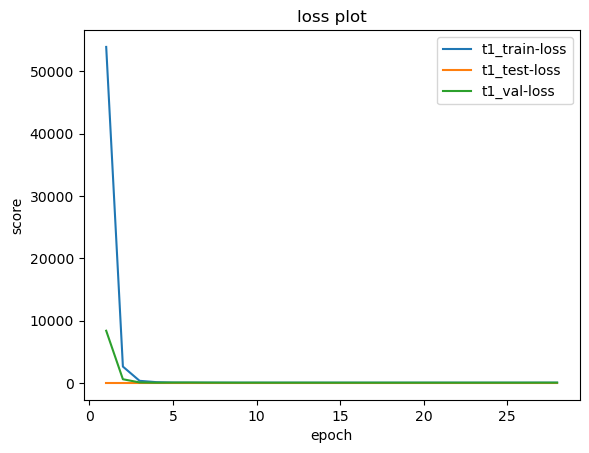

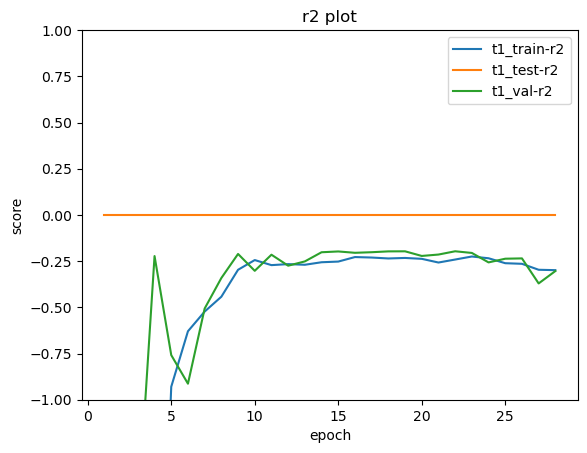

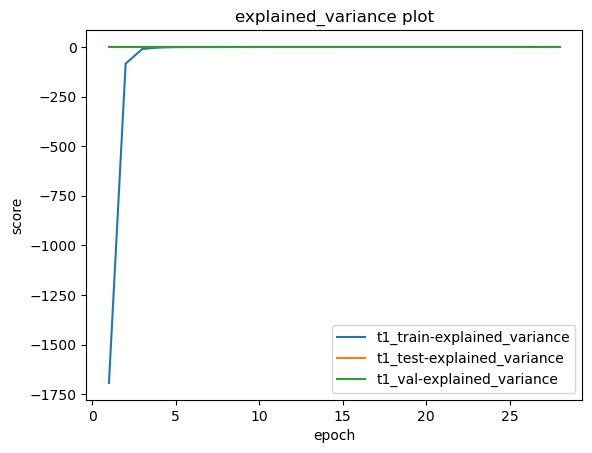

In [27]:
for what in ['loss', 'r2', 'explained_variance']:
    plt.figure()
    for config_id in df_measures.config_id.unique():
        # make subdataset for config id
        sub_df = df_measures[df_measures.config_id == config_id]

        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == 'r2':
        plt.ylim(-1,1)
    plt.legend()
    plt.show()

## Test/Debug

with open("test1.txt", "w") as file:
    file.write("config_id, epoch\n")
    file.write("0,1")

with open("test1.txt", "a") as file:
    file.write(f"\n")

import pandas as pd

pd.read_csv("test1.txt")

for x,y in train_loader:
    break

x.shape

x

y.shape

y

for i in range(1000):
    optimizer.zero_grad()
    prediction = model(x).flatten()
    loss = criterion(prediction, y)
    print(f"Epoch:{i+1} - loss:{loss}")
    loss.backward()
    optimizer.step()

y

model(x).flatten()